This code is used to calculate the surface PGF for all SBLM simulations, including those in the supporting information.  The surface PGF is estimated via central finite differencing and numerical integration in the vertical of the virtual temperature and SST. I also zonally average and taper in latitude before saving a netcdf4 file for each SBLM experiment.

Author: Alex Gonzalez (alex.gonzalez@whoi.edu). Oct 2023.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
#from netCDF4 import Dataset
import pandas as pd
#import netCDF4

from cartopy import config

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# wide latitudes
lats = -30
latn = 30

lev0 = 700
lev1 = 1000

# longitudes
lonw = 235
lone = 270

# for zonal avgs
lonw_xavg = 235
lone_xavg = 270

delta_T = 0.75 # fraction of SST gradient at p=pt
ps = 1013
pt = 850

A_factor = 1 - delta_T*(ps/(ps-pt) - 1/np.log(ps/pt))
A_factor

0.6140409231404362

In [3]:
figfolder = '/Volumes/GoogleDrive/My Drive/ITCZ_sblms_1D/ERA5/figures/'
dataset = 'ERA5'
dri = '/Volumes/alex.gonzalez/ERA5_smooth_clm/'

fn  = 'sst_1979-2021_monclm_hres.nc'
data_sst = xr.open_dataset(dri+fn,engine='netcdf4')

fn  = 'tv_1979-2021_monclm_hres.nc'
data_tv = xr.open_dataset(dri+fn)

fn  = 'mslp_1979-2021_monclm_hres.nc'
data_mslp = xr.open_dataset(dri+fn)

fn  = 'geop_1979-2021_monclm_hres.nc'
data_geop = xr.open_dataset(dri+fn)

In [4]:
data_sst

<xarray.Dataset>
Dimensions:    (time: 12, bnds: 2, longitude: 1440, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 11 16:14:32 2023: cdo ymonavg sst_1979-2021_hres.nc...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [5]:
lev = data_tv['level']
lev_int = data_tv['level'].sel(level=slice(pt,lev1))
lat = data_tv['latitude'][::-1].sel(latitude=slice(lats,latn))
mon = data_tv['time']
lev

<xarray.DataArray 'level' (level: 12)>
array([ 700,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975, 1000],
      dtype=int32)
Coordinates:
  * level    (level) int32 700 750 775 800 825 850 875 900 925 950 975 1000
Attributes:
    standard_name:  air_pressure
    long_name:      pressure_level
    units:          millibars
    positive:       down
    axis:           Z

In [6]:
def center_fd_monlatlon(field_monlatlon,phi):
    [nmon,nlat,nlon] = field_monlatlon.shape
    
    field = np.swapaxes(field_monlatlon,1,2) # swap lat and lon axes

    dfdy = np.zeros((nmon,nlon,nlat))
    #print(field[:,:,1])
    dfdy[:,:,1:nlat-1] = (field[:,:,2:nlat] - field[:,:,0:nlat-2])/(phi[2:nlat] - phi[0:nlat-2])
    dfdy[:,:,0]        = (field[:,:,1] - field[:,:,0])/(phi[1] - phi[0])
    dfdy[:,:,nlat-1]   = (field[:,:,nlat-1] - field[:,:,nlat-2])/(phi[nlat-1] - phi[nlat-2])
    dfdy_final = dfdy
    
    dfdy_final = np.swapaxes(dfdy,1,2)  # swap lat and lon axes 
    return dfdy_final

In [7]:
def center_fd_monlevlatlon(field_monlevlatlon,phi):
    [nmon,nlev,nlat,nlon] = field_monlevlatlon.shape
    
    field = np.swapaxes(field_monlevlatlon,2,3) # swap lat and lon axes

    dfdy = np.zeros((nmon,nlev,nlon,nlat))
    #print(field[:,:,1])
    dfdy[:,:,:,1:nlat-1] = (field[:,:,:,2:nlat] - field[:,:,:,0:nlat-2])/(phi[2:nlat] - phi[0:nlat-2])
    dfdy[:,:,:,0]        = (field[:,:,:,1] - field[:,:,:,0])/(phi[1] - phi[0])
    dfdy[:,:,:,nlat-1]   = (field[:,:,:,nlat-1] - field[:,:,:,nlat-2])/(phi[nlat-1] - phi[nlat-2])
    dfdy_final = np.swapaxes(dfdy,2,3)  # swap lat and lon axes 
    return dfdy_final

In [8]:
ae = 6.371e6
phi = lat*np.pi/180.

In [9]:
tv = data_tv['tv'][:,:,::-1,:].sel(level=slice(lev0,lev1),latitude=slice(lats,latn),longitude=slice(lonw,lone))
geop850 = data_geop['z'][:,:,::-1,:].sel(level=pt,latitude=slice(lats,latn),longitude=slice(lonw,lone))

sst = data_sst['sst'][:,::-1,:].sel(latitude=slice(lats,latn),longitude=slice(lonw,lone))
mslp = data_mslp['msl'][:,::-1,:].sel(latitude=slice(lats,latn),longitude=slice(lonw,lone))

In [10]:
sst_tv850_mean = ( sst+tv.sel(level=pt) )/2.

In [11]:
dtv_dy = center_fd_monlevlatlon(tv.values,phi.values)/ae + tv*0

In [12]:
dsst_dy = center_fd_monlatlon(sst.values,phi.values)/ae + sst*0

In [13]:
dtv_dy_BB09a = center_fd_monlatlon(sst_tv850_mean.values,phi.values)/ae + sst*0

In [14]:
dz_dy_850 = center_fd_monlatlon(geop850.values,phi.values)/ae + geop850*0

In [15]:
# land-sea mask
fn_lsm = '/Volumes/alex.gonzalez/ERA5_smooth_clm/lsm_era5.nc'# load the land-sea mask here and do a where statement further down   
data_lsm = xr.open_dataset(fn_lsm)
lsm = data_lsm['lsm'][0,::-1,:].sel(latitude=slice(lats,latn),longitude=slice(lonw,lone))
lsm

<xarray.DataArray 'lsm' (latitude: 241, longitude: 141)>
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.634184, 0.592892, 0.445623],
       [0.      , 0.      , 0.      , ..., 0.83831 , 0.769277, 0.762959],
       [0.      , 0.      , 0.      , ..., 0.714556, 0.702074, 0.688584]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 269.5 269.8 270.0
  * latitude   (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
    time       datetime64[ns] 1979-01-01
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

In [16]:
tv_xavg = tv.where(lsm==0).mean(dim=('longitude'))
dtv_dy_xavg = dtv_dy.where(lsm==0).mean(dim=('longitude'))
dsst_dy_xavg = dsst_dy.where(lsm==0).mean(dim=('longitude'))

dtv_dy_BB09a_xavg = dtv_dy_BB09a.where(lsm==0).mean(dim=('longitude'))
dz_dy_850_xavg = dz_dy_850.where(lsm==0).mean(dim=('longitude'))

In [17]:
dtv_dy

<xarray.DataArray 'tv' (time: 12, level: 12, latitude: 241, longitude: 141)>
array([[[[ 1.93214716e-06,  1.96727713e-06,  1.91787572e-06, ...,
           3.89503314e-06,  4.01908564e-06,  4.11130180e-06],
         [ 1.88986860e-06,  1.97769285e-06,  1.94036753e-06, ...,
           3.94166304e-06,  4.01631369e-06,  4.16067492e-06],
         [ 1.84870088e-06,  1.95134564e-06,  1.94914998e-06, ...,
           4.09315999e-06,  3.95922795e-06,  4.22050537e-06],
         ...,
         [-4.56301980e-06, -4.64700182e-06, -4.55917756e-06, ...,
          -7.81361609e-06, -7.88442420e-06, -7.87454407e-06],
         [-4.63931734e-06, -4.61516547e-06, -4.60638317e-06, ...,
          -7.98706895e-06, -7.96840622e-06, -8.03043172e-06],
         [-4.65691398e-06, -4.58336056e-06, -4.67777237e-06, ...,
          -8.11282283e-06, -8.02389985e-06, -8.11172471e-06]],

        [[ 2.22196925e-06,  2.20111086e-06,  2.24282764e-06, ...,
           3.14742403e-06,  3.35051878e-06,  3.39443121e-06],
         [ 2.18133533e-06,  2.18627554e-06,  2.21646515e-06, ...,
           3.22644412e-06,  3.37245195e-06,  3.42459762e-06],
         [ 2.10339135e-06,  2.16486839e-06,  2.16102600e-06, ...,
           3.34281125e-06,  3.34390908e-06,  3.51791100e-06],
...
         [-3.77040582e-06, -3.60683309e-06, -3.59585513e-06, ...,
          -1.42983404e-05, -1.54867129e-05, -1.63781294e-05],
         [-3.60299085e-06, -3.32359975e-06, -3.56566537e-06, ...,
          -1.37741395e-05, -1.32817748e-05, -1.42055758e-05],
         [-3.50750576e-06, -3.35271443e-06, -3.61618901e-06, ...,
          -1.36359099e-05, -1.23273185e-05, -1.34844118e-05]],

        [[ 6.29374993e-06,  6.05332939e-06,  6.11041573e-06, ...,
           3.06289235e-06,  2.62706154e-06,  2.73684261e-06],
         [ 6.14550364e-06,  6.02968498e-06,  6.16800862e-06, ...,
           3.03213317e-06,  2.64625507e-06,  2.63417929e-06],
         [ 5.94076319e-06,  5.97040359e-06,  6.04670113e-06, ...,
           2.87185361e-06,  2.82629489e-06,  2.40144504e-06],
         ...,
         [-3.90433786e-06, -4.13926777e-06, -4.37145326e-06, ...,
          -1.76384069e-05, -1.98285257e-05, -2.12842121e-05],
         [-3.65403869e-06, -4.27319981e-06, -4.09096434e-06, ...,
          -1.53429004e-05, -1.50755854e-05, -1.82087158e-05],
         [-3.68864460e-06, -4.38465681e-06, -3.86868562e-06, ...,
          -1.50389114e-05, -1.34767273e-05, -1.75122794e-05]]]])
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 269.5 269.8 270.0
  * latitude   (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
  * level      (level) int32 700 750 775 800 825 850 875 900 925 950 975 1000

In [18]:
Rd = 287.
log_piece = np.log(ps/pt)
log_piece

0.17543515476432114

In [19]:
# Estimate surface PGF from Tv_BL gradients
dTv_dy_int = ( dtv_dy.sel(level=lev_int[0])*np.log(lev_int[1]/lev_int[0]) # 850
                          + dtv_dy.sel(level=lev_int[1])*np.log(lev_int[2]/lev_int[1]) # 875 
                          + dtv_dy.sel(level=lev_int[2])*np.log(lev_int[3]/lev_int[2]) # 900
                          + dtv_dy.sel(level=lev_int[3])*np.log(lev_int[4]/lev_int[3]) # 925
                          + dtv_dy.sel(level=lev_int[4])*np.log(lev_int[5]/lev_int[4]) # 950
                          + dtv_dy.sel(level=lev_int[5])*np.log(lev_int[6]/lev_int[5]) # 975
                          + dtv_dy.sel(level=lev_int[6])*np.log(mslp/100/lev_int[6]) # 1000
                          + dsst_dy*np.log(mslp/100/lev_int[6]) ) # surface

In [20]:
dTv_dy_int_xavg = dTv_dy_int.where(lsm==0).mean(dim='longitude')

In [21]:
dTv_dy_int_xavg

<xarray.DataArray (time: 12, latitude: 241)>
array([[ 6.34063215e-07,  6.18579030e-07,  5.90857409e-07, ...,
        -4.97207243e-07, -4.77382754e-07, -3.66787328e-07],
       [ 5.88938145e-07,  5.71709672e-07,  5.41425100e-07, ...,
        -5.96450153e-07, -5.76525444e-07, -4.83477252e-07],
       [ 7.81948919e-07,  7.65584364e-07,  7.34636457e-07, ...,
        -5.73230696e-07, -5.46096026e-07, -4.69929150e-07],
       ...,
       [ 1.02891256e-06,  1.02497270e-06,  1.01593608e-06, ...,
        -2.05724168e-07, -1.68852146e-07, -1.03691225e-07],
       [ 9.35310847e-07,  9.28758802e-07,  9.15088229e-07, ...,
        -3.97685713e-07, -3.71526217e-07, -2.79538715e-07],
       [ 7.13524053e-07,  7.03249516e-07,  6.84443266e-07, ...,
        -5.30992947e-07, -5.06327040e-07, -4.09713207e-07]])
Coordinates:
  * time      (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
    level     int32 1000

In [22]:
#dtv_dy_BLavg = dtv_dy_xavg.sel(level=slice(pt,lev1)).mean(dim=('level'))

In [23]:
sst_pgf = -(dsst_dy*A_factor*Rd*log_piece - dz_dy_850)
tv_int_pgf = -(dTv_dy_int*Rd - dz_dy_850)
sst_pgf_BB09a = -(dtv_dy_BB09a*Rd*log_piece - dz_dy_850)

tv_FT_pgf = -( dtv_dy.sel(level=slice(850,900)).mean(dim=('level'))*Rd*log_piece - dz_dy_850 )
gp850_pgf = dz_dy_850

In [25]:
const = -86400

In [30]:
sst_pgf_xavg = sst_pgf.where(lsm==0).mean(dim='longitude')
tv_int_pgf_xavg = tv_int_pgf.where(lsm==0).mean(dim='longitude')
gp850_pgf_xavg = gp850_pgf.where(lsm==0).mean(dim='longitude')
tv_FT_pgf_xavg = tv_FT_pgf.where(lsm==0).mean(dim='longitude')

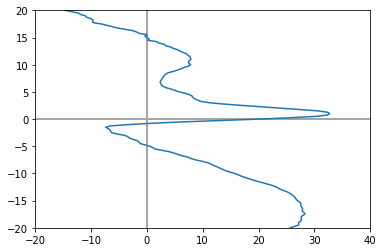

In [31]:
#plt.plot(sst_pgf[8,:]*const,dsst_dy_xavg['latitude'])
plt.plot(sst_pgf_xavg[8,:]*const,dsst_dy_xavg['latitude'])

plt.ylim(-20,20)
plt.xlim(-20,40)

plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)

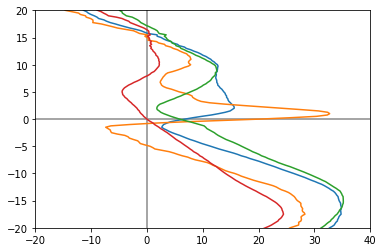

In [32]:
plt.plot(tv_int_pgf_xavg[8,:]*const,dsst_dy_xavg['latitude'])
plt.plot(sst_pgf_xavg[8,:]*const,dsst_dy_xavg['latitude'])
#sst_pgf_BB09a[8,:]*const,dsst_dy_xavg['latitude'])
plt.plot(tv_FT_pgf_xavg[8,:]*const,dsst_dy_xavg['latitude'])
plt.plot(gp850_pgf_xavg[8,:]*const,dsst_dy_xavg['latitude'])

plt.ylim(-20,20)
plt.xlim(-20,40)

plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)

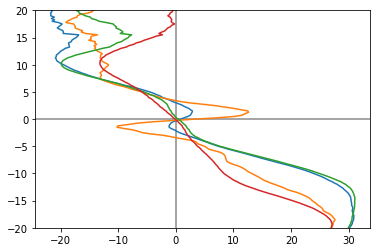

In [33]:
plt.plot(tv_int_pgf_xavg[2,:]*const,dsst_dy_xavg['latitude'])
plt.plot(sst_pgf_xavg[2,:]*const,dsst_dy_xavg['latitude'])
#plt.plot(sst_pgf_BB09a[2,:]*const,dsst_dy_xavg['latitude'])
plt.plot(tv_FT_pgf_xavg[2,:]*const,dsst_dy_xavg['latitude'])
plt.plot(gp850_pgf_xavg[2,:]*const,dsst_dy_xavg['latitude'])
plt.ylim(-20,20)

plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)

In [35]:
dro = '~/Downloads/'#'/Volumes/alexgonzalez/Google Drive/My Drive/ITCZ_sblm_1D/ERA5/progs/data_preproc/'

In [36]:
sst_pgf_final = sst_pgf_xavg
sst_pgf_final.name = 'pgf'
sst_pgf_final.attrs['long_name'] = 'Surface Pressure Gradient Force'
sst_pgf_final.attrs['method'] = 'Estimate From SST distribution'
sst_pgf_final.attrs['notes'] = 'longitudinally-averaged, ocean only'
sst_pgf_final.attrs['units'] = 'm s**-2'
sst_pgf_final

fn_output = 'pgf_sst_mon.nc'
sst_pgf_final.to_netcdf(path=dro+fn_output)

In [37]:
tv_int_pgf_final = tv_int_pgf_xavg
tv_int_pgf_final.name = 'pgf'
tv_int_pgf_final.attrs['long_name'] = 'Surface Pressure Gradient Force'
tv_int_pgf_final.attrs['method'] = 'Estimate From mass weighted vertical intergal of T_v distribution'
tv_int_pgf_final.attrs['notes'] = 'longitudinally-averaged, ocean only'
tv_int_pgf_final.attrs['units'] = 'm s**-2'
tv_int_pgf_final

fn_output = 'pgf_Tv_mon.nc'
tv_int_pgf_final.to_netcdf(path=dro+fn_output)

In [38]:
gp850_pgf_final = gp850_pgf_xavg
gp850_pgf_final.name = 'pgf'
gp850_pgf_final.attrs['long_name'] = 'Surface Pressure Gradient Force'
gp850_pgf_final.attrs['method'] = 'Estimate From 850 hPa geopotential distribution'
gp850_pgf_final.attrs['notes'] = 'longitudinally-averaged, ocean only'
gp850_pgf_final.attrs['units'] = 'm s**-2'
gp850_pgf_final

fn_output = 'pgf_gp850_mon.nc'
gp850_pgf_final.to_netcdf(path=dro+fn_output)

In [39]:
tv_FT_pgf_final = tv_FT_pgf_xavg
tv_FT_pgf_final.name = 'pgf'
tv_FT_pgf_final.attrs['long_name'] = 'Surface Pressure Gradient Force'
tv_FT_pgf_final.attrs['method'] = 'Estimate From 850-900 hPa T_v distribution'
tv_FT_pgf_final.attrs['notes'] = 'longitudinally-averaged, ocean only'
tv_FT_pgf_final.attrs['units'] = 'm s**-2'
tv_FT_pgf_final

fn_output = 'pgf_tv_FT_mon.nc'
tv_FT_pgf_final.to_netcdf(path=dro+fn_output)

In [40]:
dtv_dy_xavg_final = dtv_dy_xavg
dtv_dy_xavg_final.name = 'dtv_dy'
dtv_dy_xavg_final.attrs['long_name'] = 'Meridional Gradient of Virtual Temperature'
dtv_dy_xavg_final.attrs['notes'] = 'longitudinally-averaged, ocean only'
dtv_dy_xavg_final.attrs['units'] = 'K m**-1'
dtv_dy_xavg_final

fn_output = 'pgf_Tv_levs_mon.nc'
dtv_dy_xavg_final.to_netcdf(path=dro+fn_output)

In [41]:
# applies the Hann window at northern and southern boundaries as a function of month
def Hann_window(field_monlat,ntap):
    t = np.arange(0,ntap+1,1)
    hannl = 0.5*(1 - np.cos(2*np.pi*t/(ntap*2)))
    
    t = np.arange(ntap,ntap*2+1,1)
    hannr = 0.5*(1 - np.cos(2*np.pi*t/(ntap*2)))
    
    [nmon,nlat] = field_monlat.shape
    field = field_monlat
    fieldf = np.zeros((nmon,nlat))
    
    fieldf[:,:ntap+1] = field[:,:ntap+1]*hannl
    fieldf[:,ntap+1:nlat-ntap-1] = field[:,ntap+1:nlat-ntap-1]
    fieldf[:,nlat-ntap-1:] = field[:,nlat-ntap-1:]*hannr
    return fieldf

In [42]:
lat_sblm = lat
lat_sblm

<xarray.DataArray 'latitude' (latitude: 241)>
array([-30.  , -29.75, -29.5 , ...,  29.5 ,  29.75,  30.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [43]:
ntap = 20
pgf_sst_hann = Hann_window(sst_pgf_xavg.values,ntap)
pgf_tv_int_hann = Hann_window(tv_int_pgf_xavg.values,ntap)
pgf_gp850_hann = Hann_window(gp850_pgf_xavg.values,ntap)
pgf_tv_FT_hann = Hann_window(tv_FT_pgf_xavg.values,ntap)

In [44]:
pgf_sst_hann_xr = xr.DataArray(pgf_sst_hann, coords=[mon,lat_sblm], dims=['time','latitude'])
pgf_sst_hann_xr

<xarray.DataArray (time: 12, latitude: 241)>
array([[-0.00000000e+00, -7.81105603e-07, -3.41569531e-06, ...,
         2.06535857e-07,  3.17886080e-08, -0.00000000e+00],
       [-0.00000000e+00, -8.30077564e-07, -3.49145538e-06, ...,
        -1.76674381e-06, -4.61149670e-07, -0.00000000e+00],
       [-0.00000000e+00, -3.74105870e-07, -1.72946729e-06, ...,
        -2.41025536e-06, -6.67285441e-07, -0.00000000e+00],
       ...,
       [ 0.00000000e+00,  5.46128859e-08, -2.22648178e-07, ...,
         1.73030011e-06,  3.70522410e-07,  0.00000000e+00],
       [-0.00000000e+00, -3.77536988e-07, -1.83242810e-06, ...,
         1.36685856e-06,  2.67694660e-07, -0.00000000e+00],
       [-0.00000000e+00, -6.40684194e-07, -2.83799893e-06, ...,
         4.45214461e-07,  2.30662801e-08, -0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0

In [45]:
pgf_tv_int_hann_xr = xr.DataArray(pgf_tv_int_hann, coords=[mon,lat_sblm], dims=['time','latitude'])
pgf_gp850_hann_xr = xr.DataArray(pgf_gp850_hann, coords=[mon,lat_sblm], dims=['time','latitude'])
pgf_tv_FT_hann_xr = xr.DataArray(pgf_tv_FT_hann, coords=[mon,lat_sblm], dims=['time','latitude'])

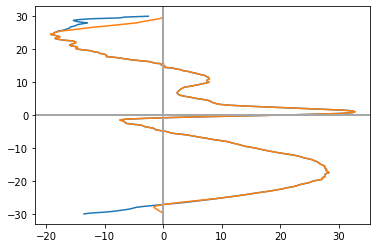

In [48]:
plt.plot(sst_pgf_xavg[8,:]*const,lat)
plt.plot(pgf_sst_hann_xr[8,:]*const,lat)

plt.axvline(0, color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

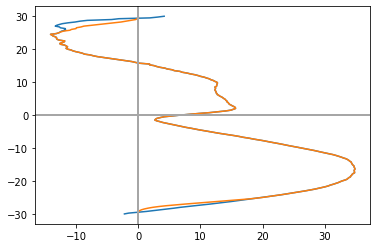

In [49]:
plt.plot(tv_int_pgf_xavg[8,:]*const,lat)
plt.plot(pgf_tv_int_hann_xr[8,:]*const,lat)

plt.axvline(0, color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

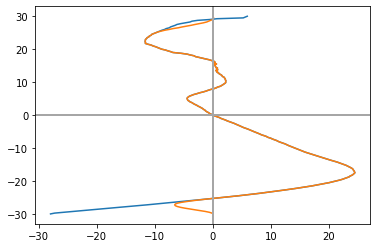

In [50]:
plt.plot(gp850_pgf_xavg[8,:]*const,lat)
plt.plot(pgf_gp850_hann_xr[8,:]*const,lat)

plt.axvline(0, color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

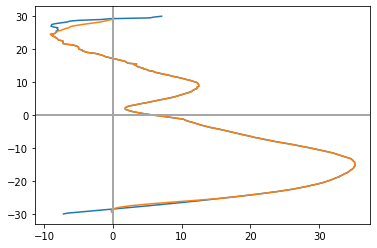

In [51]:
plt.plot(tv_FT_pgf_xavg[8,:]*const,lat)
plt.plot(pgf_tv_FT_hann_xr[8,:]*const,lat)

plt.axvline(0, color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

In [52]:
pgf_sst_hann_xr.name = 'pgf'
pgf_sst_hann_xr.attrs['long_name'] = 'Surface Pressure Gradient Force'
pgf_sst_hann_xr.attrs['method'] = 'Estimate From SST distribution'
pgf_sst_hann_xr.attrs['notes'] = 'longitudinally-averaged, ocean only'
pgf_sst_hann_xr.attrs['units'] = 'm s**-2'
pgf_sst_hann_xr.attrs['dataset'] = 'ERA5'
pgf_sst_hann_xr.attrs['taper'] = 'Tapering within 5 degrees of north and south boundaries'
pgf_sst_hann_xr

fn_output = 'pgf_sst_forcing.nc'
pgf_sst_hann_xr.to_netcdf(path=dro+fn_output)

In [53]:
pgf_tv_int_hann_xr.name = 'pgf'
pgf_tv_int_hann_xr.attrs['long_name'] = 'Surface Pressure Gradient Force'
pgf_tv_int_hann_xr.attrs['method'] = 'Estimate From mass weighted vertical intergal of T_v distribution'
pgf_tv_int_hann_xr.attrs['notes'] = 'longitudinally-averaged, ocean only'
pgf_tv_int_hann_xr.attrs['units'] = 'm s**-2'
pgf_tv_int_hann_xr.attrs['dataset'] = 'ERA5'
pgf_tv_int_hann_xr.attrs['taper'] = 'Tapering within 5 degrees of north and south boundaries'
pgf_tv_int_hann_xr

fn_output = 'pgf_Tv_forcing.nc'
pgf_tv_int_hann_xr.to_netcdf(path=dro+fn_output)

In [54]:
pgf_gp850_hann_xr.name = 'pgf'
pgf_gp850_hann_xr.attrs['long_name'] = 'Surface Pressure Gradient Force'
pgf_gp850_hann_xr.attrs['method'] = 'Estimate From 850 hPa geopotential distribution'
pgf_gp850_hann_xr.attrs['notes'] = 'longitudinally-averaged, ocean only'
pgf_gp850_hann_xr.attrs['units'] = 'm s**-2'
pgf_gp850_hann_xr.attrs['dataset'] = 'ERA5'
pgf_gp850_hann_xr.attrs['taper'] = 'Tapering within 5 degrees of north and south boundaries'
pgf_gp850_hann_xr

fn_output = 'pgf_gp850_forcing.nc'
pgf_gp850_hann_xr.to_netcdf(path=dro+fn_output)

In [55]:
pgf_tv_FT_hann_xr.name = 'pgf'
pgf_tv_FT_hann_xr.attrs['long_name'] = 'Surface Pressure Gradient Force'
pgf_tv_FT_hann_xr.attrs['method'] = 'Estimate From 850-900 hPa T_v distribution'
pgf_tv_FT_hann_xr.attrs['notes'] = 'longitudinally-averaged, ocean only'
pgf_tv_FT_hann_xr.attrs['units'] = 'm s**-2'
pgf_tv_FT_hann_xr.attrs['dataset'] = 'ERA5'
pgf_tv_FT_hann_xr.attrs['taper'] = 'Tapering within 5 degrees of north and south boundaries'
pgf_tv_FT_hann_xr

fn_output = 'pgf_tv_FT_forcing.nc'
pgf_tv_FT_hann_xr.to_netcdf(path=dro+fn_output)